<small><i>This notebook was put together by [Wesley Beckner](http://wesleybeckner.github.io/).</i></small>

<a id='top'></a>

## 2D descriptor selection

load json parsing [here](#json)

load descriptor generation [here](#descriptors)

check datasets [here](#check)

In [2]:
import json
import os
import sys
import pandas as pd
import numpy as np
import salty
from __future__ import print_function

#rdkit modules
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as Calculator

#pychem modules
# import pychem 
# from pychem.pychem import PyChem2d, PyChem3d

#scikit modules
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#plot modules and formatting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", facecolor="white")
params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<a id='json'></a>

# Parse ILThermo Data - Append Descriptors From Database

[back to top](#top)

In [8]:
###a hacky hack solution to cleaning raw ILThermo data
df = pd.read_csv("../salty/data/viscosity_full.csv")
uniqueSalts = pd.DataFrame(df["salt_name"].unique(), columns=["salts"])
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})

anions=[]
cations=[]
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        #two word cation
        if"tris(2-hydroxyethyl) methylammonium" in salts['salts'].iloc[i]:
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            anions.append(salts['salts'].iloc[i].split()[2])
            cations.append(first + ' ' + second)
            
        #these strings have two word anions
        elif("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("bis(trifluoromethylsulfonyl)imide" in salts['salts'].iloc[i]): 
            #this string contains 2 word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
        else:
            print(salts['salts'].iloc[i])
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")    
    else:
        print(salts['salts'].iloc[i])
anions = pd.DataFrame(anions, columns=["name-anion"])
# anions = anions[0].unique()
cations = pd.DataFrame(cations, columns=["name-cation"])
# cations = cations[0].unique()

In [9]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [10]:
new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
                    df["Viscosity, Pas"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df.dropna(inplace=True) #remove entires not in smiles database

In [11]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/viscosity_premodel.csv', index=False)

<a id='json'></a>

# Parse JSON files

[back to top](#top)

In [2]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()

for i in range(2266):
    with open("../salty/data/DENSITY/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])
        print(json_saltname.iloc[0][3])
        
        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()
        
        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new
            
        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           
        
        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
print(outer_old)
pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/density.csv', index=False)

1-hexyl-3-methylimidazolium bis[(trifluoromethyl)sulfonyl]imide
1-butyl-3-methylimidazolium tetrafluoroborate
1-butyl-3-methylimidazolium methylsulfate
1-ethyl-3-methylimidazolium ethyl sulfate
2-hydroxy-N-methylethanaminium pentanoate
2-hydroxy-N-methylethanaminium propionate
N-methyl-2-hydroxyethylammonium acetate
2-hydroxy-N-methylethanaminium formate
2-hydroxy-N-methylethanaminium isobutyrate
N-methyl-2-hydroxyethylammonium butanoate
1-butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
1-ethyl-3-methylimidazolium ethyl sulfate
1-butyl-3-methylimidazolium tetrafluoroborate
1-butyl-3-methylimidazolium hexafluorophosphate
1-hexyl-3-methylimidazolium hexafluorophosphate
1-ethyl-3-methylimidazolium tetrafluoroborate
1-octyl-3-methylimidazolium hexafluorophosphate
1-hexyl-3-methylimidazolium tetrafluoroborate
tetradecyl(trihexyl)phosphonium dicyanamide
1-butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
1-butyl-3-methylimidazolium octyl sulfate
1-butyl-3-methylimidazol

KeyboardInterrupt: 

In [3]:
###read in the salts csv; add cat_name, an_name, cat_SMILES, and an_SMILES
###columns. Parse salt_name into cation and anion components and append to
###respective columns. Make the call to checkName with those entries and
###append to respective SMILES columns.
from salty import check_name as checkName
salts=pd.read_csv('../salty/data/density.csv',delimiter=',')
salts['cation_name'] = np.nan
salts['anion_name'] = np.nan
salts['cation_SMILES'] = np.nan
salts['anion_SMILES'] = np.nan
for i in range(salts.shape[0]):
    salts.ix[i, 'cation_name'] = salts['salt_name'].iloc[i].split()[0]
    try:
        salts.ix[i, 'cation_SMILES'] = salty.checkName(salts['cation_name'].iloc[i])
    except:
        pass
    if len(salts['salt_name'].iloc[i].split()) == 2:
        salts.ix[i, 'anion_name'] = salts['salt_name'].iloc[i].split()[1]
    elif len(salts['salt_name'].iloc[i].split()) == 1:
        print("only one compound listed")
    else:
        print("long anion name")
        salts.ix[i, 'anion_name'] = (salts['salt_name'].iloc[i].split()[1] + \
        " " + salts['salt_name'].iloc[i].split()[2])
    try:
        salts.ix[i, 'anion_SMILES'] = salty.checkName(salts['anion_name'].iloc[i])
    except:
        pass

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':


long anion name
long anion name
only one compound listed
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
only one compound listed
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long a

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long anion name
long ani

In [6]:
pd.DataFrame.to_csv(salts, path_or_buf='../salty/data/salts_with_smiles.csv', index=False)

In [7]:
###remove all the salts not found in our database and
###save the truncated salt data
salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
salts = salts.loc[salts['cation_SMILES'] != "0"]
salts = salts.loc[salts['cation_SMILES'] != "0.0"]
salts = salts.loc[salts['anion_SMILES'] != "0"]
salts = salts.loc[salts['anion_SMILES'] != "0.0"]
salts['salt_SMILES'] = salts['cation_SMILES'] + " " + salts['anion_SMILES']
pd.DataFrame.to_csv(salts, path_or_buf='../salty/data/salts_with_smiles.csv', index=False)

In [4]:
import salty

In [5]:
salty.check_name("1-methylimidazolium")

UnboundLocalError: local variable 'target_lookup' referenced before assignment

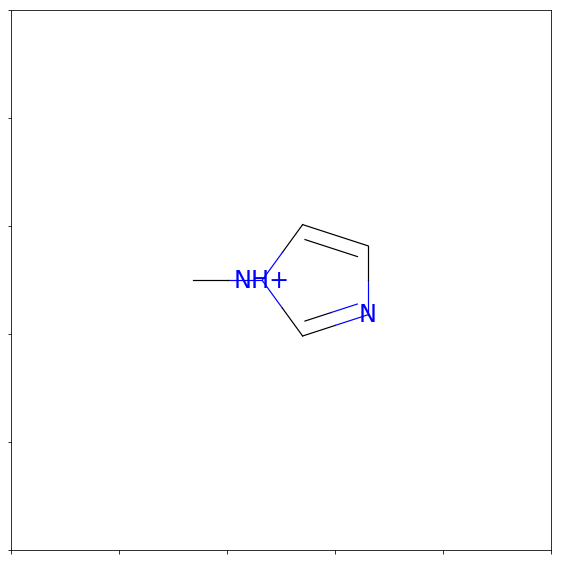

In [25]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles("n1cc[nH+](c1)C")
a = Draw.MolToMPL(mol)

<a id='descriptors'></a>

# Create Descriptors - RDKit version 0.2.0

[back to top](#top)

In [5]:
###based on coco's Deslist
data=pd.read_csv('../../salty/data/anionInfo.csv',delimiter=',')
n = data.shape[0]
f = open('../../salty/data/Deslist','r')
Deslist = []
for line in f:
    Deslist.append(line.strip('\n\t'))
calc = Calculator(Deslist)
D = len(Deslist)
d = D
X = np.zeros((n,d+2))
for i in range(n):
    cation = Chem.MolFromSmiles(data.smiles[i])
    X[i][2:]   = calc.CalcDescriptors(cation)
cols = [s for s in Deslist]
cols = ["name" , "smiles"] + cols
X = pd.DataFrame(X, columns=cols)
X.iloc[:,0] = data.name
X.iloc[:,1] = data.smiles
pd.DataFrame.to_csv(X, path_or_buf='../../salty/data/anionDescriptors.csv', index=False)

In [12]:
cationDescriptors = pd.read_csv("../salty/data/cationDescriptors.csv")
cationDescriptors.loc[cationDescriptors["name"] == "trihexyl(tetradecyl)-phosphonium"]

,name,smiles,steiger,Marsili Partial Charges,BalabanJ,BertzCT,Ipc,HallKierAlpha,Kappa1,Kappa2,...,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10,Topliss fragments
154,trihexyl(tetradecyl)-phosphonium,C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC,777.0,777.0,4.337445,319.128267,1.312721e+07,0.43,33.43,27.024749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.805556,0.0,777.0


In [42]:
df = pd.read_csv("../salty/data/viscosity_full.csv")

In [14]:
###a hacky hack solution to cleaning raw ILThermo data
df = pd.read_csv("../salty/data/viscosity.csv")
uniqueSalts = pd.DataFrame(df["salt_name"].unique(), columns=["salts"])
salts = uniqueSalts
anions=[]
cations=[]
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        df["cation"][i] = (salts['salts'].iloc[i].split()[0])
        df["anion"][i] = (salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        #two word cation
        if"tris(2-hydroxyethyl) methylammonium" in salts['salts'].iloc[i]:
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            anions.append(salts['salts'].iloc[i].split()[2])
            cations.append(first + ' ' + second)
            
        #these strings have two word anions
        elif("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("bis(trifluoromethylsulfonyl)imide" in salts['salts'].iloc[i]): 
            #this string contains 2 word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
        else:
            print(salts['salts'].iloc[i])
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")    
    else:
        print(salts['salts'].iloc[i])
anions = pd.DataFrame(anions)
anions = anions[0].unique()
cations = pd.DataFrame(cations)
cations = cations[0].unique()

KeyError: 'cation'

<a id='descriptors'></a>

# Create Descriptors - RDKit version

[back to top](#top)

In [9]:
###based on coco's Deslist
data=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
print(data.columns)
n = data.shape[0]
f = open('../salty/data/Deslist','r')
Deslist = []
for line in f:
    Deslist.append(line.strip('\n\t'))
calc = Calculator(Deslist)
D = len(Deslist)
d = len(Deslist)*2+6
print(n,d)

Index(['Molar volume, m<SUP>3</SUP>/mol', 'Pressure, kPa',
       'Specific density, kg/m<SUP>3</SUP>',
       'Specific volume, m<SUP>3</SUP>/kg', 'Temperature, K', 'salt_name',
       'cation_name', 'anion_name', 'cation_SMILES', 'anion_SMILES',
       'salt_SMILES'],
      dtype='object')
9172 194


In [12]:
X = np.zeros((n,d))
X[:,-3] = data['Temperature, K']
X[:,-2] = data['Pressure, kPa']
for i in range(n):
    cation = Chem.MolFromSmiles(data['cation_SMILES'][i])
    anion  = Chem.MolFromSmiles(data['anion_SMILES'][i])
    X[i][:D]    = calc.CalcDescriptors(cation)
    X[i][D:2*D] = calc.CalcDescriptors(anion)

X[:,-1] = data['Specific density, kg/m<SUP>3</SUP>']

cols_cat = [s + "-cation" for s in Deslist]
cols_ani = [s + "-anion" for s in Deslist]
cols = cols_cat + cols_ani + ["salt_name" , "NAME_CAT", "NAME_ANI", "Temperature_K" , "Pressure_kPa", "Density_kg/m"]

X = pd.DataFrame(X, columns=cols)
X.iloc[:,-6] = data['salt_name']
X.iloc[:,-5] = data['cation_name']
X.iloc[:,-4] = data['anion_name']

print(X.shape)

# pd.DataFrame.to_csv(X, path_or_buf='../salty/data/salts_with_descriptors.csv', index=False)

(9172, 194)


<a id='descriptors'></a>

# Create Descriptors - Pychem version

[back to top](#top)

In [25]:
datadf = salts.loc[salts["cation_name"].str.contains("ammonium", case=False)]
datadf = datadf.reset_index(drop=True)
datadf

,index,"Molar volume, m<SUP>3</SUP>/mol","Pressure, kPa","Specific density, kg/m<SUP>3</SUP>","Specific volume, m<SUP>3</SUP>/kg","Temperature, K",salt_name,cation_name,anion_name,cation_SMILES,anion_SMILES,salt_SMILES
0,9,NaN,101.325,1800.00,NaN,298.15,ammonium dinitramide,ammonium,dinitramide,[NH4+],[N-]([N+](=O)[O-])[N+](=O)[O-],[NH4+] [N-]([N+](=O)[O-])[N+](=O)[O-]
1,56,NaN,101.325,1840.00,NaN,293.00,ammonium dinitramide,ammonium,dinitramide,[NH4+],[N-]([N+](=O)[O-])[N+](=O)[O-],[NH4+] [N-]([N+](=O)[O-])[N+](=O)[O-]
2,59,NaN,101.325,1818.30,NaN,293.00,ammonium dinitramide,ammonium,dinitramide,[NH4+],[N-]([N+](=O)[O-])[N+](=O)[O-],[NH4+] [N-]([N+](=O)[O-])[N+](=O)[O-]
3,75,NaN,101.325,1840.00,NaN,293.00,ammonium dinitramide,ammonium,dinitramide,[NH4+],[N-]([N+](=O)[O-])[N+](=O)[O-],[NH4+] [N-]([N+](=O)[O-])[N+](=O)[O-]
4,99,NaN,101.000,966.82,NaN,298.15,propylammonium acetate,propylammonium,acetate,CCC[NH3+],CC(=O)[O-],CCC[NH3+] CC(=O)[O-]
5,103,NaN,101.325,1695.00,NaN,293.00,ammonium dinitramide,ammonium,dinitramide,[NH4+],[N-]([N+](=O)[O-])[N+](=O)[O-],[NH4+] [N-]([N+](=O)[O-])[N+](=O)[O-]
6,105,NaN,101.325,978.00,NaN,300.15,2-methylpropylammonium formate,2-methylpropylammonium,formate,CC(C)C[NH3+],C(=O)[O-],CC(C)C[NH3+] C(=O)[O-]
7,1579,NaN,100.000,996.10,NaN,293.15,propylammonium formate,propylammonium,formate,CCC[NH3+],C(=O)[O-],CCC[NH3+] C(=O)[O-]
8,1580,NaN,100.000,993.40,NaN,298.15,propylammonium formate,propylammonium,formate,CCC[NH3+],C(=O)[O-],CCC[NH3+] C(=O)[O-]
9,1581,NaN,100.000,990.80,NaN,303.15,propylammonium formate,propylammonium,formate,CCC[NH3+],C(=O)[O-],CCC[NH3+] C(=O)[O-]


In [27]:
###READ SMILES INTO PYCHEM AND CREATE DATAFRAME
salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
salts = salts[salts.anion_name != 'chloride']  #chloride returns an error in pychem
salts = salts[salts.anion_name != 'bromide']  #bromide returns an error in pychem
salts = salts[salts.cation_name != 'ammonium']  #ammonium returns an error in pychem
salts = salts[salts.anion_name != 'trifluorotris(perfluoroethyl)phosphate(V)'] #returns an error in pychem
salts = salts[salts.anion_name != 'iodide'] #returns an error in pychem
salts = salts.reset_index()
cats = pd.DataFrame(columns=salts['cation_name']) #loop through all the salts
old = pd.DataFrame()
new = pd.DataFrame()
for a, b in enumerate(salts['cation_name']):    
    catdes=[] #descriptors for cations
    andes=[] #descriptors for anions
    cat=PyChem2d() #create PyChem molecular instances
    an=PyChem2d()
    print(b,salts['anion_SMILES'][a]) #check that we're computing
    cat.ReadMolFromSmile(np.str(salts['cation_SMILES'][a])) #cation
    an.ReadMolFromSmile(np.str(salts['anion_SMILES'][a])) #anion
    andes.append(an.GetAllDescriptor()) 
    catdes.append(cat.GetAllDescriptor()) #add all the descriptors    
    dfan = pd.DataFrame(andes) #turn the array into a dataframe
    dfcat = pd.DataFrame(catdes)
    dfan.rename(columns=lambda x: x + '-anion', inplace=True) #rename headers (cation or anion)
    dfcat.rename(columns=lambda x: x + '-cation', inplace=True)
    df = pd.concat([dfcat, dfan], axis=1) #concatonate cationic and anionic descriptor df's
    if a != 0: #grow the dataframe
        new = pd.concat([df, old], axis=0)
    old = new

1-ethyl-3-methylimidazolium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
1-methyl-3-octylimidazolium [B-](F)(F)(F)F
1-hexyl-3-methylimidazolium [B-](F)(F)(F)F
1-hexyl-3-methylimidazolium [B-](F)(F)(F)F
1-ethyl-3-methylimidazolium [B-](F)(F)(F)F
1-hexyl-3-methylimidazolium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
1-allyl-3-methyl-1H-imidazol-3-ium CCC(=O)[O-]
1-hexyl-3-methylimidazolium [B-](F)(F)(F)F
1-ethyl-3-methylimidazolium [B-](F)(F)(F)F
1-ethyl-3-methylimidazolium CCOS(=O)(=O)[O-]
1-ethyl-3-methylimidazolium C(F)(F)(F)S(=O)(=O)[O-]
1-ethyl-3-methylimidazolium C(F)(F)(F)S(=O)(=O)[O-]
1-ethyl-3-methylimidazolium [B-](F)(F)(F)F
trihexyl(tetradecyl)phosphonium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium [B-](F)(F)(F)F
1-ethyl-3-methylimidazolium [B-](F)(F)(F)F
1-hexyl-3-methylimidazolium [B-](F)(F)(F)F
1-hexyl-3-methylimidazolium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
1-hexyl-3-methylimidazolium C(C(F)(F)S(=O)(=O)[N-]S(=

In [29]:
###Append these values in a separate step since 
###calculating the descriptors is computationally expensive

desc = new.iloc[::-1]
desc=desc.reset_index(drop=True)
desc.loc[:,'Temperature_K'] = pd.Series(salts['Temperature, K'], index=desc.index)
for a in range(len(salts['Temperature, K'])):
    desc.iloc[a-1,-1] = salts['Temperature, K'][a]
desc.loc[:,'Pressure_kPa'] = pd.Series(salts['Pressure, kPa'], index=desc.index)
for a in range(len(salts['Pressure, kPa'])):
    desc.iloc[a-1,-1] = salts['Pressure, kPa'][a]
desc.loc[:,'NAME_CAT'] = pd.Series(salts['cation_name'], index=desc.index)
for a in range(len(salts['cation_name'])):
    desc.iloc[a-1,-1] = salts['cation_name'][a]
desc.loc[:,'NAME_ANI'] = pd.Series(salts['anion_name'], index=desc.index)
for a in range(len(salts['anion_name'])):
    desc.iloc[a-1,-1] = salts['anion_name'][a]
desc.loc[:,'Density_kg/m'] = pd.Series(salts['Specific density, kg/m<SUP>3</SUP>'], index=desc.index)
for a in range(len(salts['Specific density, kg/m<SUP>3</SUP>'])):
    desc.iloc[a-1,-1] = salts['Specific density, kg/m<SUP>3</SUP>'][a]

In [30]:
pd.DataFrame.to_csv(desc, path_or_buf='../salty/data/salts_with_pychem_descriptors.csv', index=False)

<a id='check'></a>

# Check Dataset

[back to top](#top)

In [35]:
data=pd.read_csv('../salty/data/salts_with_pychem_descriptors.csv')
# data = data.loc[data["NAME_CAT"].str.contains("octyl", case=False)]
data

,ATSe1-cation,ATSe2-cation,ATSe3-cation,ATSe4-cation,ATSe5-cation,ATSe6-cation,ATSe7-cation,ATSe8-cation,ATSm1-cation,ATSm2-cation,...,slogPVSA5-anion,slogPVSA6-anion,slogPVSA7-anion,slogPVSA8-anion,slogPVSA9-anion,Temperature_K,Pressure_kPa,NAME_CAT,NAME_ANI,Density_kg/m
0,2.770,2.881,2.601,2.427,2.334,2.232,2.119,1.991,2.773,2.883,...,0.0,0.0,0.000,0.0,17.263,298.15,101.325,1-methyl-3-octylimidazolium,tetrafluoroborate,1102.00
1,2.636,2.762,2.441,2.232,2.119,1.991,1.818,1.426,2.639,2.764,...,0.0,0.0,0.000,0.0,17.263,298.15,101.325,1-hexyl-3-methylimidazolium,tetrafluoroborate,1144.50
2,2.636,2.762,2.441,2.232,2.119,1.991,1.818,1.426,2.639,2.764,...,0.0,0.0,0.000,0.0,17.263,298.15,101.000,1-hexyl-3-methylimidazolium,tetrafluoroborate,1146.70
3,2.299,2.470,1.991,1.426,0.693,0.000,0.000,0.000,2.303,2.473,...,0.0,0.0,0.000,0.0,17.263,293.10,101.325,1-ethyl-3-methylimidazolium,tetrafluoroborate,1296.00
4,2.636,2.762,2.441,2.232,2.119,1.991,1.818,1.426,2.639,2.764,...,0.0,0.0,4.127,0.0,26.342,298.15,101.325,1-hexyl-3-methylimidazolium,bis[(trifluoromethyl)sulfonyl]imide,1370.80
5,2.394,2.551,2.138,1.818,1.426,0.693,0.000,0.000,2.398,2.554,...,0.0,0.0,0.000,0.0,0.000,298.15,101.325,1-allyl-3-methyl-1H-imidazol-3-ium,propionate,1086.00
6,2.636,2.762,2.441,2.232,2.119,1.991,1.818,1.426,2.639,2.764,...,0.0,0.0,0.000,0.0,17.263,298.00,101.325,1-hexyl-3-methylimidazolium,tetrafluoroborate,1143.90
7,2.299,2.470,1.991,1.426,0.693,0.000,0.000,0.000,2.303,2.473,...,0.0,0.0,0.000,0.0,17.263,298.15,101.300,1-ethyl-3-methylimidazolium,tetrafluoroborate,1279.00
8,2.299,2.470,1.991,1.426,0.693,0.000,0.000,0.000,2.303,2.473,...,0.0,0.0,0.000,0.0,0.000,298.15,101.300,1-ethyl-3-methylimidazolium,ethyl sulfate,1228.00
9,2.299,2.470,1.991,1.426,0.693,0.000,0.000,0.000,2.303,2.473,...,0.0,0.0,0.000,0.0,13.171,298.15,101.325,1-ethyl-3-methylimidazolium,trifluoromethanesulfonate,1383.60
